# Diffusion Auto Encoder

This is a implementation from [audio-diffusion-pytorch](https://github.com/archinetai/audio-diffusion-pytorch). 

In [17]:
import torch
from torch.utils.data import DataLoader

from src.datasets import MusicCapsDataset
from src.features import PreProcessor
from src.features.extractor import WaveformExtractor
from src.models import DiffusionAE
from src.models.callbacks import MetricsCallback
from src.utils.data import TorchDataset
from src.visualization import ChartsViewer
from src.utils.audio import Audio

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

## Data Preparation

### Generate Dataset

Each Musiccaps dataset has 10-second audios. To adapt to this model we will apply the following changes to the data:

* We will divide the data into two parts of 5.5 seconds. Each part of the audio will have two times: from 0 to 5.5 and 4.5 to 10 seconds.
* For each new audio, we will add information to the 'aspect list' and 'caption' explaining the audio track. For example '1 of 2' or '2 of 2'.

In [3]:
musiccaps_generator = MusicCapsDataset(format="mp3", crop_length=5.5)
dataset = musiccaps_generator.generate(num_proc=1)

### Preprocessing the data

For the format defined by the article, we need to cut the song to size 2**18 (approximately 5.5 seconds), so that it adapts to the network input

In [4]:
# Tip: We don't need to save waveforms.
train, test = PreProcessor(dataset, lambda dataset : WaveformExtractor(dataset, column="audio", crop_length=2**18)).get_train_test_split(path=musiccaps_generator.get_processed_folder(), save_split_sets=False)

Loading train/test indexes...


Generating test subset [Waveform]: 100%|██████████| 2178/2178 [01:37<00:00, 22.27it/s]


## Training

### Parameters

In [5]:
NUM_EPOCHS = 5
BATCH_SIZE = 8
DECODE_STEPS = 100
MODEL_BEST = "best-epoch"
MODEL_RESULT = "last-epoch"
SAMPLING_RATE = 48000

### Adapting train data

We need to adapt the standard pytorch data:

* The pattern suggested in the documentation is [batch, in_channels, length]. In our case, our dataset is in the format [batch, length]. (length is the multiplication of frequency by time).
* We need to use DataLoader, an optimized implementation to access our data.
* We take the opportunity to use the gpu, if available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
transform = lambda x: x.unsqueeze(0) # (batch, length) ->  (batch, 1, length)

train_dataset = TorchDataset(train[:20], transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Model definition

We use the same as the original example. We add an optimizer to update the parameters of the model based on the gradients computed during backpropagation.
The loss is calculated internally.

In [7]:
autoencoder = DiffusionAE()
run_folder = autoencoder.get_run_folder()
print(run_folder)

models/DiffusionAE//run_2023-11-17_16-58-15


In [8]:
# Callbacks
last_checkpoint_callback = ModelCheckpoint(
    dirpath=run_folder,  
    filename=MODEL_RESULT,  
    save_last=True,  
    save_weights_only=True,
)

best_checkpoint_callback = ModelCheckpoint(
    dirpath=run_folder,  
    filename=MODEL_BEST, 
    monitor='train_loss',  
    mode='min',  
    save_top_k=1, 
    save_weights_only=True,
)

metrics_callback = MetricsCallback()

callbacks = [last_checkpoint_callback,
                  best_checkpoint_callback, 
                  metrics_callback]


### Training loop

In [9]:
# Configurar treinamento
trainer = pl.Trainer(
    max_epochs=5,  # Número de épocas
    callbacks=callbacks,
    default_root_dir=run_folder
)

# Treinar o modelo
trainer.fit(model=autoencoder, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
e:\text-to-music\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: models\DiffusionAE\run_2023-11-17_16-58-15\lightning_logs
e:\text-to-music\.venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:630: Checkpoint directory E:\text-to-music\models\DiffusionAE\run_2023-11-17_16-58-15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


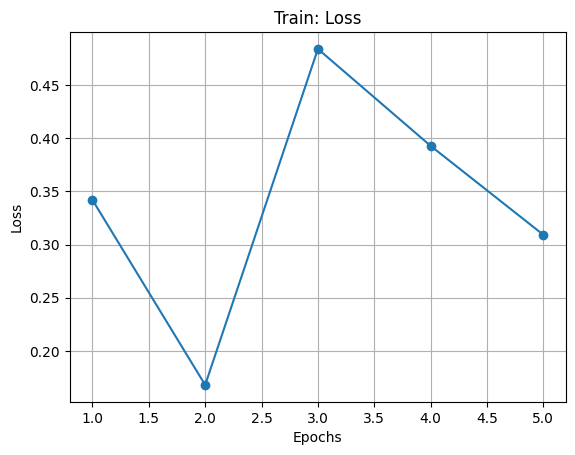

In [10]:
logged_metrics = metrics_callback.metrics
losses_values = []

# Exiba as métricas
for metric_dict in logged_metrics:
    for metric_name, metric_value in metric_dict.items():
        losses_values.append(metric_value.cpu())
        
ChartsViewer.get_line_chart(losses_values, title="Train: Loss", x_label="Epochs", y_label="Loss")

In [11]:
test_dataset = TorchDataset(test[:1], transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
autoencoder.eval()

generated_audios = torch.empty(0, device=device) 

with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        latent = autoencoder.encode(batch)
        generated_audio = autoencoder.decode(latent, num_steps=DECODE_STEPS)
        generated_audio = generated_audio.to(device)
        generated_audios = torch.cat((generated_audios, generated_audio), dim=0)

In [18]:
Audio.save(generated_audios.cpu().numpy(), sample_rate=SAMPLING_RATE, folder_path=run_folder) 